In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
!pip install contractions

     |████████████████████████████████| 245kB 7.1MB/s 
     |████████████████████████████████| 317kB 39.0MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81698 sha256=58a0bc073084b5cd98c06efb1e432b01560f712361f45723e59bf50d0f67e1d0
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [ ]:
## Import packages
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from keras.utils import np_utils
import contractions
import numpy as np
import re
from IPython.display import Image
from IPython.core.display import HTML 
import tqdm
import unicodedata
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

In [ ]:
## load training and testing dataset
train = pd.read_csv('/content/gdrive/My Drive/lily/train.csv')
test = pd.read_csv('/content/gdrive/My Drive/lily/test.csv')

output_map = {'Animal Diseases': 0,
 'Bacterial Infections and Mycoses': 3,
 'Cardiovascular Diseases': 1,
 'Chemically-Induced Disorders': 2,
 'Congenital Hereditary and Neonatal Diseases and Abnormalities': 4,
 'Digestive System Diseases': 5,
 'Disorders of Environmental Origin': 22,
 'Endocrine System Diseases': 6,
 'Eye Diseases': 7,
 'Female Urogenital Diseases and Pregnancy Complications': 8,
 'Hemic and Lymphatic Diseases': 9,
 'Immune System Diseases': 10,
 'Male Urogenital Diseases': 11,
 'Musculoskeletal Diseases': 24,
 'Neoplasms': 12,
 'Nervous System Diseases': 13,
 'Nutritional and Metabolic Diseases': 14,
 'Occupational Diseases': 15,
 'Otorhinolaryngologic Diseases': 16,
 'Parasitic Diseases': 17,
 'Pathological Conditions and Signs and Symptoms': 18,
 'Respiratory Tract Diseases': 19,
 'Skin and Connective Tissue Diseases': 25,
 'Stomatognathic Diseases': 20,
 'Virus Diseases': 21,
 'Wounds and Injuries': 23}

train['categories'] = train['categories'].map(output_map)
test['categories'] = test['categories'].map(output_map)
validation = test.sample(5000)

Basic Text Pre-processing
We do minimal text pre-processing here since we are using deep learning models and not count-based methods. Steps include the following:



Converting accented characters
* Removal of stopwords
*   Fixing contractions
*   Removing special characters
*   Converting accented characters

Note : For some models we don't use any pre-processing like BERT!

In [ ]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def pre_process_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        doc = doc.translate(doc.maketrans("\n\t\r", "   "))
        doc = doc.lower()
        doc = remove_accented_chars(doc)
        doc = contractions.fix(doc)
        # lower case and remove special characters\whitespaces
        doc = re.sub(r'[^a-zA-Z0-9\s]', ' ', doc, re.I|re.A)
        doc = re.sub(' +', ' ', doc)
        doc = doc.strip()  
        norm_docs.append(doc)
    return norm_docs

In [ ]:
%%time
train_content = pre_process_corpus(list(train['abstract']))
valid_content = pre_process_corpus(list(validation['abstract']))

100%|██████████| 5000/5000 [00:00<00:00, 5494.53it/s]

CPU times: user 8.6 s, sys: 60.6 ms, total: 8.67 s
Wall time: 8.67 s


convert target variable to one hot encoding since its a multiclass classification problem

In [ ]:
train_rating = np_utils.to_categorical(train['categories'])
valid_rating = np_utils.to_categorical(validation['categories'])

Building input pipeline

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_content, train_rating))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((valid_content, valid_rating))
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(64)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

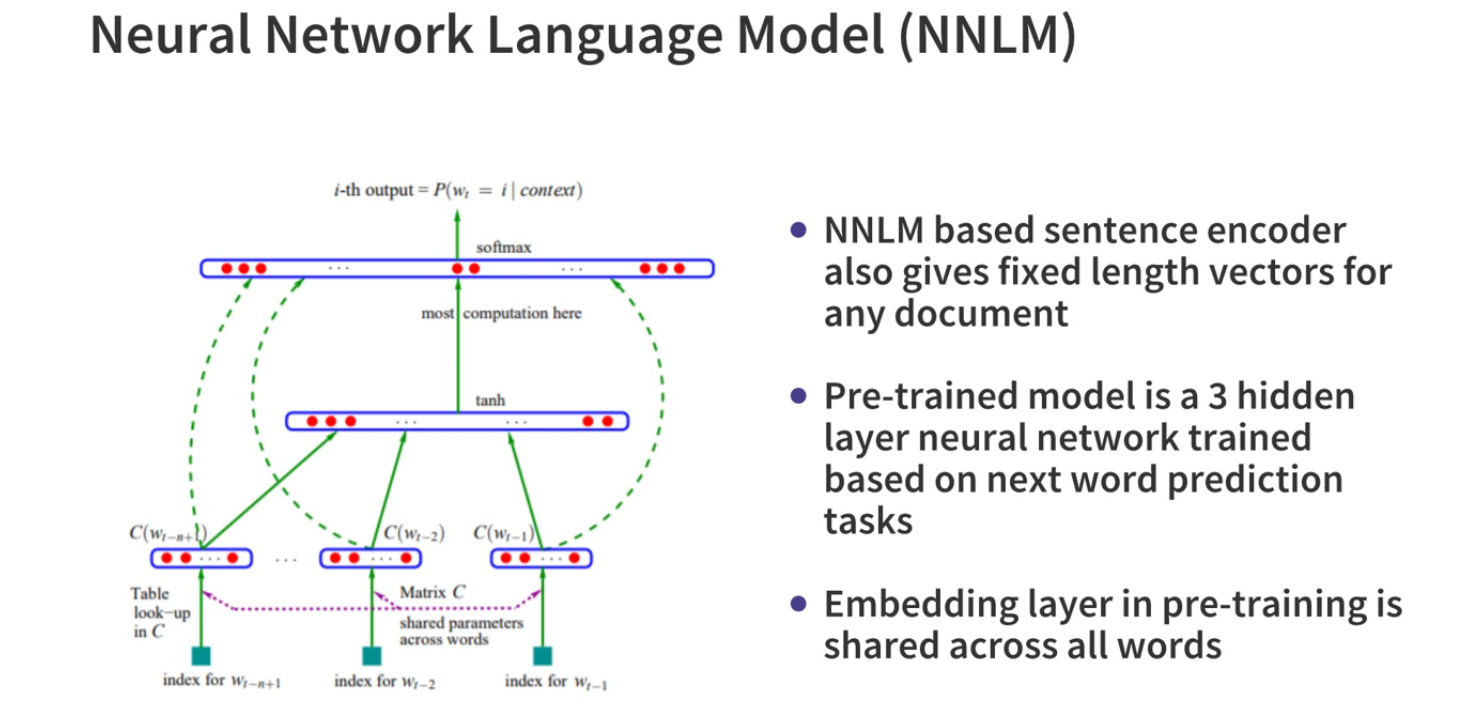

In [ ]:
from IPython.core.display import Image, display
display(Image('nnm.PNG'))

Build a NNLM Embedding Layer

In [ ]:
model = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
hub_layer = hub.KerasLayer(model, output_shape=[128], input_shape=[], 
                           dtype=tf.string, trainable=True)

Build Model Architecture

In [ ]:

model = tf.keras.models.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.15))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.15))
model.add(tf.keras.layers.Dense(26, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 26)                3354      
Total params: 124,679,066
Trainable params: 124,679,066
Non-trainable params: 0
__________________________________________

Define callbacks

In [ ]:
filepath = '/content/gdrive/My Drive/lily/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    save_weights_only=False,
    save_best_only=True)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=5,
                                      restore_best_weights=True,
                                      verbose=1)

Train the model

In [ ]:

    
model.fit(train_dataset,
          validation_data = test_dataset,
          epochs=1000, 
          shuffle=True,
          callbacks=[model_checkpoint_callback],
          verbose=1)

Epoch 1/1000
687/687 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 0.9975INFO:tensorflow:Assets written to: /content/gdrive/My Drive/lily/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/lily/assets


687/687 [==============================] - 92s 134ms/step - loss: 0.0111 - accuracy: 0.9975 - val_loss: 6.4342 - val_accuracy: 0.6440
Epoch 2/1000
687/687 [==============================] - 84s 123ms/step - loss: 0.0090 - accuracy: 0.9977 - val_loss: 6.5357 - val_accuracy: 0.6554
Epoch 3/1000
687/687 [==============================] - 83s 120ms/step - loss: 0.0092 - accuracy: 0.9973 - val_loss: 6.8640 - val_accuracy: 0.6422
Epoch 4/1000
687/687 [==============================] - 83s 121ms/step - loss: 0.0115 - accuracy: 0.9970 - val_loss: 6.4465 - val_accuracy: 0.6588
Epoch 5/1000
687/687 [==============================] - 83s 121ms/step - loss: 0.0094 - accuracy: 0.9974 - val_loss: 6.5515 - val_accuracy: 0.6558
Epoch 6/1000
687/687 [==============================] - 83s 121ms/step - loss: 0.0088 - accuracy: 0.9980 - val_loss: 7.2039 - val_accuracy: 0.6542
Epoch 7/1000
687/687 [==============================] - 83s 121ms/step - loss: 0.0081 - accuracy: 0.9977 - val_loss: 6.9669 - val_a